# COOKIE AMIP cloud on - cloud off: change in precipitation and circulaton metrics

This notebook reproduces Table 1.

Data: COOKIE amip on and off simulations, time-avergaed between years 1980 and 2008. Data is used on the models' native horizontal grids.

### Load libraries

In [1]:
import xarray as xr
import numpy as np

Functions for calculating ITCZ and Jet:

In [2]:
import metrics as mt

For reference, print package versions to screen:

In [3]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)

xarrary:    0.15.1
numpy:      1.18.1


### Load data

In [4]:
models=['CNRM-CM5', 'HadGEM2-A', 'IPSL-CM5A-LR', 'MPI-CM5', 'MRI-CGCM3']

Precipitation and zonal wind at 850 hPa:

In [5]:
def load_pr_ua850(var, varname, exp):
    ds_list = []
    for mod in models:
        ds_list.append( ( xr.open_dataset('../../data/cookie/'+var+'_'+mod+'_'+exp+'.timmean_1980-2008.nc')
                         [varname].mean('lon').squeeze() ) )
    return ds_list

p_on  = load_pr_ua850('pr'   , 'pr', 'amip'      )
p_off = load_pr_ua850('pr'   , 'pr', 'offamip_mm')
u_on  = load_pr_ua850('ua850', 'ua', 'amip'      )
u_off = load_pr_ua850('ua850', 'ua', 'offamip_mm')

/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Mass stream function calculated by cdo mastrfu:

In [6]:
def load_msf(exp):
    ds_list = []
    for mod in models:
        ds = ( xr.open_dataset('../../data/cookie/msf_'+mod+'_'+exp+'.timmean_1980-2008.nc')
                         ['mastrfu'].squeeze() )
        if mod == 'MPI-CM5': # rename lev to plev to be consistent with other models
            ds = ds.rename({'lev': 'plev'})
        ds = ds/1.0e9 # adapt units of mass stream function
        ds_list.append(ds)        
            
    return ds_list

msf_on  = load_msf('amip'      )
msf_off = load_msf('offamip_mm')

### Calculate precipitation and circulation metrics

#### 1. Change in regional precipitation 

In [7]:
dp_glob = [] # global mean
dp_trop = [] # tropical mean
dp_extr = [] # extratropical mean

for i in range(len(p_on)):
    # define surface area weights
    weights   =  p_on[i] + np.cos(np.deg2rad(p_on[i].lat.values))
    # global mean
    aux = 86400*(p_on[i].values - p_off[i].values) 
    dp_glob.append( np.average(aux, weights=weights) )
    # tropical mean
    aux = 86400*(p_on[i].sel(lat=slice(-30,30)).values - p_off[i].sel(lat=slice(-30,30)).values)
    dp_trop.append( np.average(aux, weights=weights.sel(lat=slice(-30,30))) )
    # extratropical mean
    aux = 86400*(p_on[i].sel(lat=slice(-90,-30)).values -  p_off[i].sel(lat=slice(-90,-30)).values)
    sh = np.average(aux, weights=weights.sel(lat=slice(-90,-30)))
    aux = 86400*(p_on[i].sel(lat=slice(30,90)).values -  p_off[i].sel(lat=slice(30,90)).values)
    nh = np.average(aux, weights=weights.sel(lat=slice(30,90)))
    dp_extr.append( 0.5*(nh+sh) )

#### 2. Change in ITCZ position

In [8]:
ditcz = []
for i in range(len(p_on)):
    itcz_on  = mt.get_itczposition(p_on[i],  p_on[i].lat )
    itcz_off = mt.get_itczposition(p_off[i], p_off[i].lat)
    ditcz.append(itcz_on-itcz_off)

#### 3. Change in Hadley cell strength

In [9]:
dhc_sh = []
dhc_nh =[]
for i in range(len(models)):
    dhc_sh.append( -1* ( msf_on[i].sel(lat=slice(-30,0), plev=slice(850e2,200e2)).max().values -
                         msf_off[i].sel(lat=slice(-30,0), plev=slice(850e2,200e2)).max().values ) )
    dhc_nh.append( msf_on[i].sel(lat=slice(0,30), plev=slice(850e2,200e2)).max().values -
                   msf_off[i].sel(lat=slice(0,30), plev=slice(850e2,200e2)).max().values )

#### 4. Change in jet position and strength

In [10]:
djetpos_nh = [] # NH jet position
djetpos_sh = [] # SH jet position
djetmag_nh = [] # NH jet strength
djetmag_sh = [] # SH jet strength

for i in range(len(u_on)):
    jetpos_sh_on , jetmag_sh_on , jetpos_nh_on , jetmag_nh_on  = mt.get_eddyjetlatint(u_on[i] , u_on[i].lat )
    jetpos_sh_off, jetmag_sh_off, jetpos_nh_off, jetmag_nh_off = mt.get_eddyjetlatint(u_off[i], u_off[i].lat)
    djetpos_nh.append(    jetpos_nh_on-jetpos_nh_off)
    djetpos_sh.append(-1*(jetpos_sh_on-jetpos_sh_off) )
    djetmag_nh.append(jetmag_nh_on-jetmag_nh_off)
    djetmag_sh.append(jetmag_sh_on-jetmag_sh_off)

### Print to screen in latex-ready format

In [11]:
print('model            Ptrop     Pextr     Pglob    ITCZ    NHHC   SHHC   NHJetpos SHJetpos NHJetmag SHJetmag')
for i in range(len(models)):
    print('{:12s}'.format(models[i]), ' & ', 
          '{:3.2f}'.format(dp_trop[i].round(decimals=2)), ' & ', 
          '{:3.2f}'.format(dp_extr[i].round(decimals=2)), ' & ', 
          '{:3.2f}'.format(dp_glob[i].round(decimals=2)), ' & ',
          '{:1.1f}'.format(ditcz[i].round(decimals=1))  , ' & ', 
          '{:3.0f}'.format(dhc_nh[i].round(decimals=0)) , ' & ', 
          '{:3.0f}'.format(dhc_sh[i].round(decimals=0)) , ' & ',
          '{:4.1f}'.format(djetpos_nh[i].round(decimals=1)), ' & ',
          '{:4.1f}'.format(djetpos_sh[i].round(decimals=1)), ' & ',
          '{:4.1f}'.format(djetmag_nh[i].round(decimals=1)), ' & ',
          '{:4.1f}'.format(djetmag_sh[i].round(decimals=1)), ' \\')

model            Ptrop     Pextr     Pglob    ITCZ    NHHC   SHHC   NHJetpos SHJetpos NHJetmag SHJetmag
CNRM-CM5      &  -0.24  &  0.20  &  -0.02  &  0.3  &   11  &   -1  &   0.1  &  -1.6  &   0.2  &  -0.5  \
HadGEM2-A     &  -0.27  &  0.12  &  -0.07  &  1.0  &  -14  &    9  &  -1.2  &  -0.4  &   0.5  &  -0.1  \
IPSL-CM5A-LR  &  -0.31  &  0.15  &  -0.08  &  0.0  &   -5  &   -4  &   6.3  &  -1.0  &   1.1  &   1.1  \
MPI-CM5       &  -0.29  &  0.21  &  -0.04  &  1.0  &   -2  &   -3  &  -0.6  &  -2.0  &   0.4  &  -0.7  \
MRI-CGCM3     &  -0.35  &  0.08  &  -0.14  &  0.9  &  -25  &    4  &   7.5  &   1.1  &   0.6  &   0.4  \


### Illustration of the flat meridional profile of zonal wind in IPSL-CM5A-LR and MRI-CGCM3, which leads to the large diagnosed NH jet shifts, MPI-CM5 for comparison

In [12]:
import matplotlib.pyplot as plt

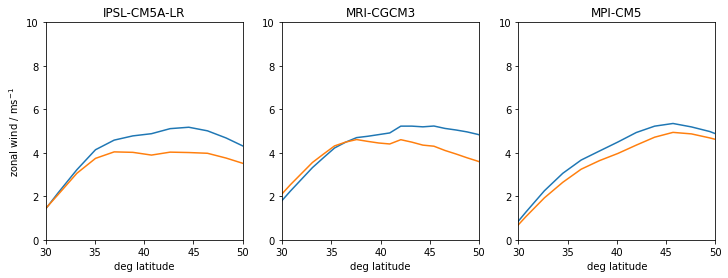

In [13]:
plt.figure(figsize=(12,4))

# IPSL-CM5A-LR
plt.subplot(1,3,1)
plt.title(models[2])
plt.plot(u_on[2].lat, u_on[2].values)
plt.plot(u_on[2].lat, u_off[2].values)
plt.xlim(30,50)
plt.ylim(0,10)
plt.ylabel(r'zonal wind / ms$^{-1}$');
plt.xlabel('deg latitude');

# MRI-CGCM3
plt.subplot(1,3,2)
plt.title(models[4])
plt.plot(u_on[4].lat, u_on[4].values)
plt.plot(u_on[4].lat, u_off[4].values)
plt.xlim(30,50)
plt.ylim(0,10)
plt.xlabel('deg latitude');

# MPI-CM5
plt.subplot(1,3,3)
plt.title(models[3])
plt.plot(u_on[3].lat, u_on[3].values)
plt.plot(u_on[3].lat, u_off[3].values)
plt.xlim(30,50)
plt.ylim(0,10)
plt.xlabel('deg latitude');